# Denoising Diffusion Probabilistic Models with MedNIST Dataset

This tutorial compares the different schedulers available for sampling from a trained model with a reduced number of timesteps. The schedulers we will compare are:

[1] - DDPM - Ho et al. "Denoising Diffusion Probabilistic Models" https://arxiv.org/abs/2006.11239

[2] - DDIM - Song et al. "Denoising Diffusion Implicit Models" https://arxiv.org/abs/2010.02502

[3] - PNDM - Liu et al. "Pseudo Numerical Methods for Diffusion Models on Manifolds" https://arxiv.org/abs/2202.09778


TODO: Add Open in Colab

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.utils import first, set_determinism
from tqdm import tqdm

# TODO: Add right import reference after deployed
from generative.networks.nets import DiffusionModelUNet
from generative.schedulers import DDIMScheduler, DDPMScheduler, PNDMScheduler

print_config()

MONAI version: 1.1.dev2246
Numpy version: 1.23.3
Pytorch version: 1.8.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c81b9467b43bb14e77956729d10f2aef4d69deec
MONAI __file__: /media/walter/Storage/Projects/GenerativeModels/venv/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.2.0
Tensorboard version: 2.11.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.9.0+cu111
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.3
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.6.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai

## Setup data directory

You can specify a directory with the MONAI_DATA_DIRECTORY environment variable.

This allows you to save results and reuse downloads.

If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpmk0ge830


## Set deterministic training for reproducibility

In [4]:
set_determinism(0)

## Setup MedNIST Dataset and training and validation dataloaders
In this tutorial, we will train our models on the MedNIST dataset available on MONAI
(https://docs.monai.io/en/stable/apps.html#monai.apps.MedNISTDataset). In order to train faster, we will select just
one of the available classes ("Hand"), resulting in a training set with 7999 2D images.

In [5]:
train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, seed=0)
train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "Hand"]

MedNIST.tar.gz: 59.0MB [00:03, 17.1MB/s]                                                                                                                                                                                        

2022-11-25 23:04:35,119 - INFO - Downloaded: /tmp/tmpmk0ge830/MedNIST.tar.gz


2022-11-25 23:04:35,192 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2022-11-25 23:04:35,192 - INFO - Writing into directory: /tmp/tmpmk0ge830.


Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47164/47164 [00:14<00:00, 3260.23it/s]


Here we use transforms to augment the training dataset:

1. `LoadImaged` loads the hands images from files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `ScaleIntensityRanged` extracts intensity range [0, 255] and scales to [0, 1].
1. `RandAffined` efficiently performs rotate, scale, shear, translate, etc. together based on PyTorch affine transform.

In [6]:
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            spatial_size=[64, 64],
            padding_mode="zeros",
            prob=0.5,
        ),
    ]
)
train_ds = CacheDataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4, persistent_workers=True)

Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7999/7999 [00:04<00:00, 1746.60it/s]


In [7]:
val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, seed=0)
val_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "Hand"]
val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)
val_ds = CacheDataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=4, persistent_workers=True)

2022-11-25 23:04:58,982 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2022-11-25 23:04:58,982 - INFO - File exists: /tmp/tmpmk0ge830/MedNIST.tar.gz, skipped downloading.
2022-11-25 23:04:58,983 - INFO - Non-empty folder exists in /tmp/tmpmk0ge830/MedNIST, skipped extracting.


Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7999/7999 [00:04<00:00, 1803.09it/s]


### Visualisation of the training images

batch shape: (128, 1, 64, 64)


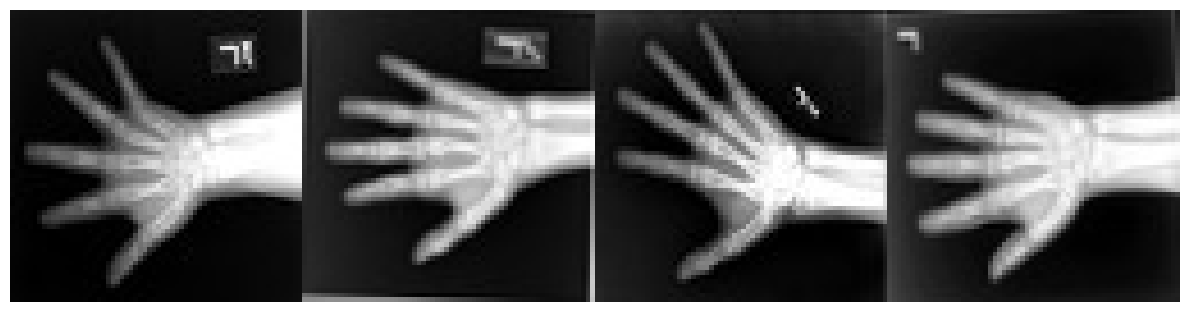

In [8]:
check_data = first(train_loader)
print(f"batch shape: {check_data['image'].shape}")
image_visualisation = torch.cat(
    [check_data["image"][0, 0], check_data["image"][1, 0], check_data["image"][2, 0], check_data["image"][3, 0]], dim=1
)
plt.figure("training images", (12, 6))
plt.imshow(image_visualisation, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

### Define network and optimizer
At this step, we instantiate the MONAI components to create a DDPM, a 2D unet with attention mechanisms
in the 2nd and 4th levels, each with 1 attention head.

In [9]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(64, 128, 128),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=128,
)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), 2.5e-5)

### Define schedulers

We use a DDPM scheduler with 1000 steps for training. For sampling, we will compare the DDPM, DDIM, and PNDM.

In [10]:
ddpm_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
)
ddim_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
)
pndm_scheduler = PNDMScheduler(num_train_timesteps=1000, skip_prk_steps=True)

# the range of sampling steps we want to use when testing the DDIM and PNDM schedulers
sampling_steps = [1000, 500, 200, 50]

### Define helper function for sampling

In [11]:
def sample(model, scheduler, noise):
    image = noise.clone()
    progress_bar = tqdm(scheduler.timesteps)
    progress_bar.set_description(f"Epoch {epoch} - Sampling from {scheduler.__class__.__name__}...")
    for t in progress_bar:
        # 1. predict noise model_output
        with torch.no_grad():
            model_output = model(image, torch.Tensor((t,)).to(device))
        # 2. compute previous image: x_t -> x_t-1
        image, _ = scheduler.step(model_output, t, image)
    return image

### Model training
Here, we are training our model for 100 epochs (training time: ~40 minutes). It is necessary to train for a bit longer than other tutorials because the DDIM and PNDM schedules seem to require a model trained longer before they start producing good samples, when compared to DDPM.

Epoch 9 - Sampling from PNDMScheduler...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 70.11it/s]


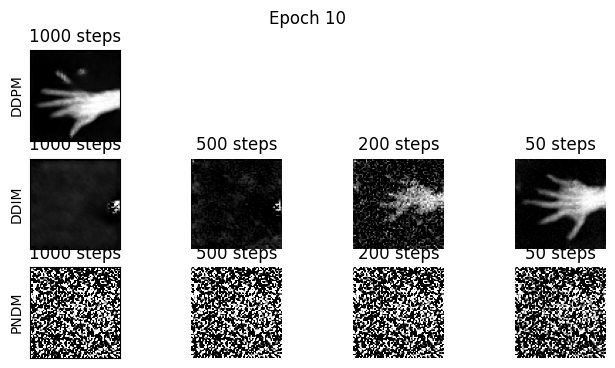

Epoch 19 - Sampling from PNDMScheduler...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 70.43it/s]


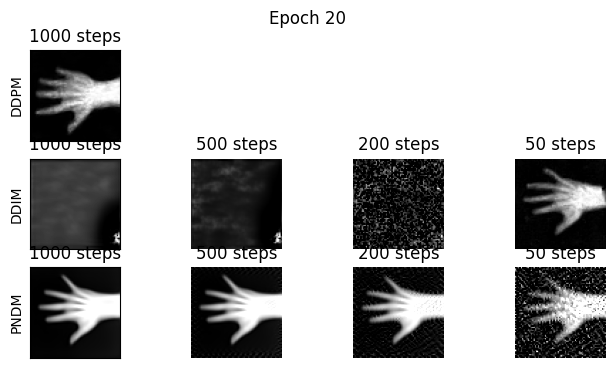

Epoch 29 - Sampling from PNDMScheduler...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 71.27it/s]


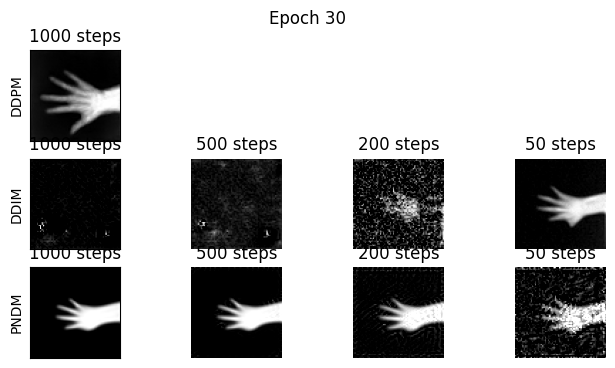

Epoch 39 - Sampling from PNDMScheduler...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 69.95it/s]


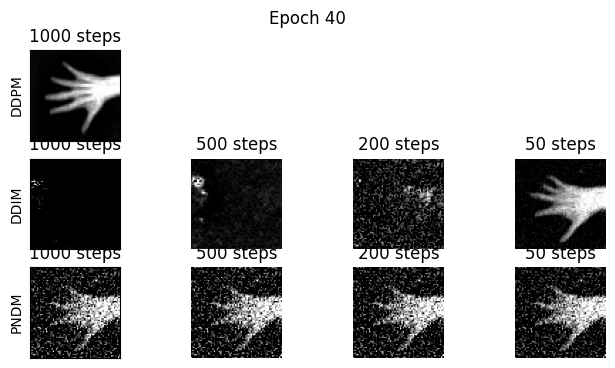

Epoch 49 - Sampling from PNDMScheduler...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 70.36it/s]


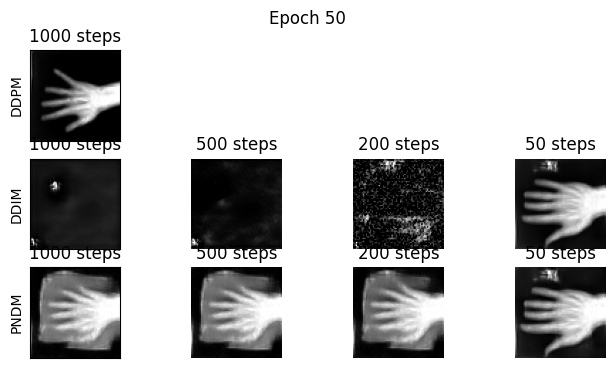

Epoch 59 - Sampling from PNDMScheduler...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 68.66it/s]


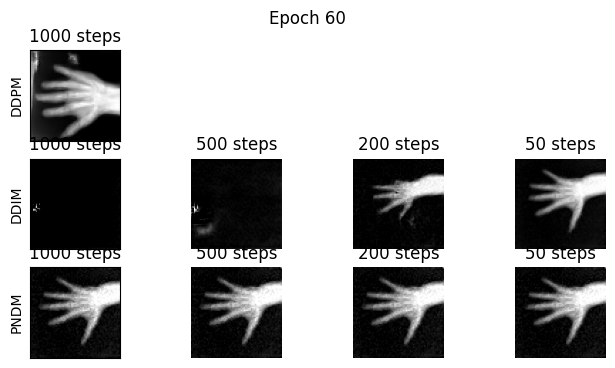

Epoch 69 - Sampling from PNDMScheduler...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 71.06it/s]


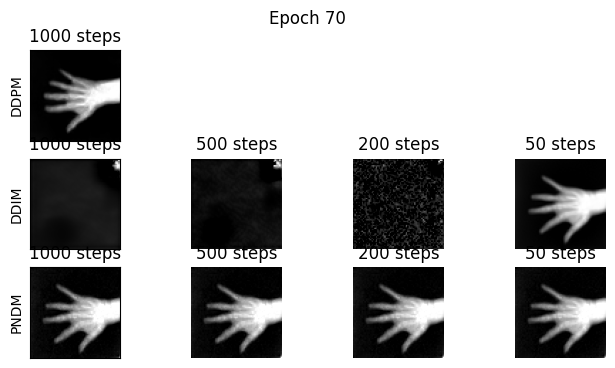

Epoch 79 - Sampling from PNDMScheduler...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 68.85it/s]


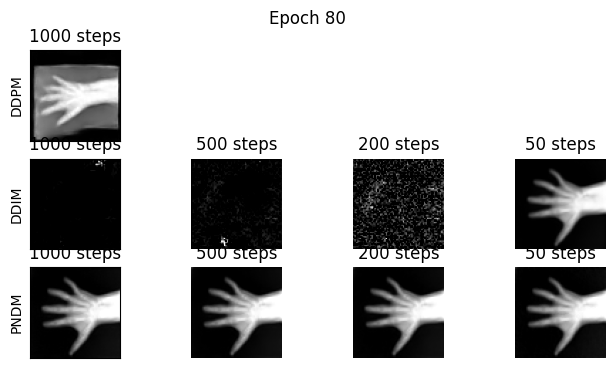

Epoch 89 - Sampling from PNDMScheduler...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 70.76it/s]


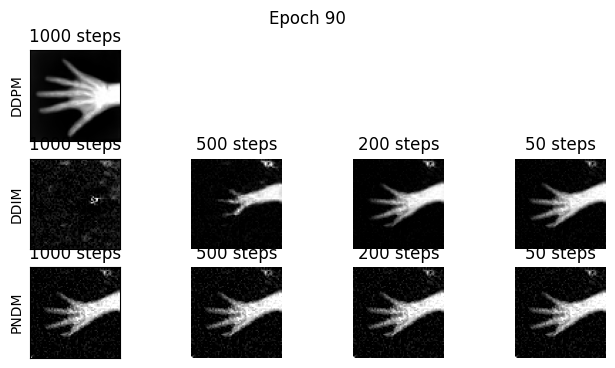

Epoch 99 - Sampling from PNDMScheduler...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 68.93it/s]


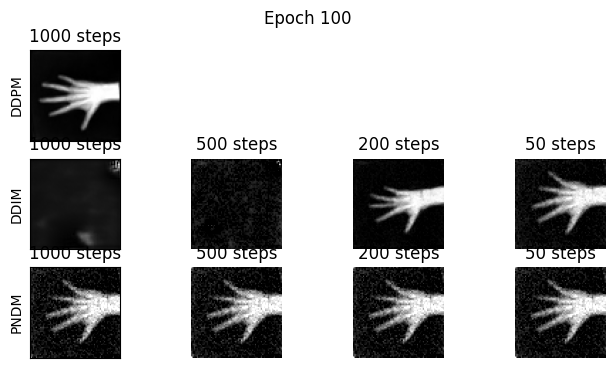

In [12]:
n_epochs = 100
val_interval = 10
epoch_loss_list = []
val_epoch_loss_list = []
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer.zero_grad(set_to_none=True)

        # Randomly select the timesteps to be used for the minibacth
        timesteps = torch.randint(0, ddpm_scheduler.num_train_timesteps, (images.shape[0],), device=device).long()

        # Add noise to the minibatch images with intensity defined by the scheduler and timesteps
        noise = torch.randn_like(images).to(device)
        noisy_image = ddpm_scheduler.add_noise(original_samples=images, noise=noise, timesteps=timesteps)

        # In this example, we are parametrising our DDPM to learn the added noise (epsilon).
        # For this reason, we are using our network to predict the added noise and then using L1 loss to predict
        # its performance.
        noise_pred = model(x=noisy_image, timesteps=timesteps)
        loss = F.l1_loss(noise_pred.float(), noise.float())

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        progress_bar.set_postfix(
            {
                "loss": epoch_loss / (step + 1),
            }
        )
    epoch_loss_list.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        progress_bar = tqdm(enumerate(val_loader), total=len(train_loader))
        progress_bar.set_description(f"Epoch {epoch} - Validation set")
        for step, batch in progress_bar:
            images = batch["image"].to(device)
            timesteps = torch.randint(0, ddpm_scheduler.num_train_timesteps, (images.shape[0],), device=device).long()
            noise = torch.randn_like(images).to(device)
            with torch.no_grad():
                noisy_image = ddpm_scheduler.add_noise(original_samples=images, noise=noise, timesteps=timesteps)
                noise_pred = model(x=noisy_image, timesteps=timesteps)
                val_loss = F.l1_loss(noise_pred.float(), noise.float())

            val_epoch_loss += val_loss.item()
            progress_bar.set_postfix(
                {
                    "val_loss": val_epoch_loss / (step + 1),
                }
            )
        val_epoch_loss_list.append(val_epoch_loss / (step + 1))

        # Sampling image during training
        noise = torch.randn((1, 1, 64, 64))
        noise = noise.to(device)
        ddpm_scheduler.set_timesteps(1000)
        image = sample(model, ddpm_scheduler, noise)
        plt.figure(figsize=(8, 4))
        plt.subplot(3, len(sampling_steps), 1)
        plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
        plt.ylabel("DDPM")
        plt.title("1000 steps")
        # DDIM
        for idx, reduced_sampling_steps in enumerate(sampling_steps):
            ddim_scheduler.set_timesteps(reduced_sampling_steps)
            image = sample(model, ddim_scheduler, noise)
            plt.subplot(3, len(sampling_steps), len(sampling_steps) + idx + 1)
            plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
            plt.ylabel("DDIM")
            if idx == 0:
                plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
            else:
                plt.axis("off")
            plt.title(f"{reduced_sampling_steps} steps")
        # PNDM
        for idx, reduced_sampling_steps in enumerate(sampling_steps):
            pndm_scheduler.set_timesteps(reduced_sampling_steps)
            image = sample(model, pndm_scheduler, noise)
            plt.subplot(3, len(sampling_steps), len(sampling_steps) * 2 + idx + 1)
            plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
            plt.ylabel("PNDM")
            if idx == 0:
                plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
            else:
                plt.axis("off")
            plt.title(f"{reduced_sampling_steps} steps")
        plt.suptitle(f"Epoch {epoch+1}")
        plt.show()

### Learning curves

/tmp/ipykernel_6568/3570577212.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


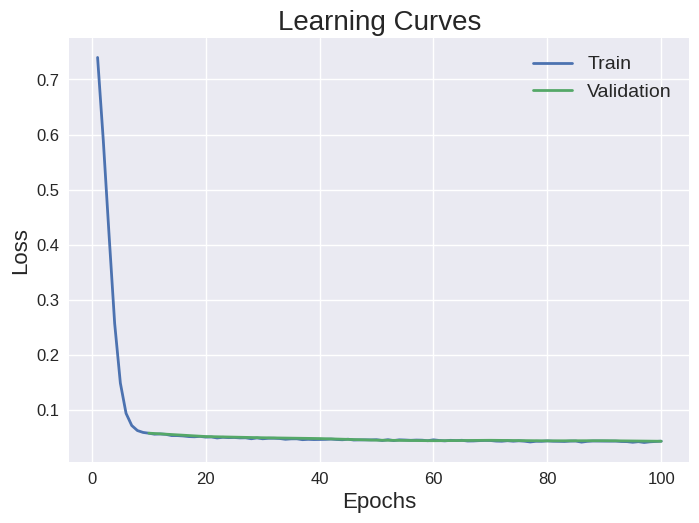

In [13]:
plt.style.use("seaborn")
plt.title("Learning Curves", fontsize=20)
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_loss_list, color="C0", linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)),
    val_epoch_loss_list,
    color="C1",
    linewidth=2.0,
    label="Validation",
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

### Cleanup data directory
Remove directory if a temporary was used

In [14]:
if directory is None:
    shutil.rmtree(root_dir)